In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold

from xgboost import XGBClassifier, plot_importance

import shap 

from ipywidgets import interact_manual, fixed, widgets 

%matplotlib inline

## Importing data, renaming columns, creating extra columns

In [2]:
project_dir = '/Users/keltim01/git_repos/TK5/Data/Big-Data-Cup-2021/'
womens = pd.read_csv(project_dir + 'hackathon_womens.csv')
nwhl = pd.read_csv(project_dir + 'hackathon_nwhl.csv')
womens = womens.append(nwhl, ignore_index=True)
womens.columns = ['game_date', 'home_team', 'away_team', 'period', 'clock',
       'home_team_skaters', 'away_team_skaters', 'home_team_goals',
       'away_team_goals', 'team', 'player', 'event', 'x_coord',
       'y_coord', 'detail_1', 'detail_2', 'detail_3', 'detail_4',
       'player_2', 'x_coord_2', 'y_coord_2']
womens['game_id'] = womens.loc[:, ['game_date', 'home_team', 'away_team']].sum(axis=1).astype('category').cat.codes
womens['is_home'] = 0 
womens['is_shot'] = 0
womens['is_goal'] = 0
womens['event_id'] = womens['event'].astype('category').cat.codes
womens['team_id'] = womens['team'].astype('category').cat.codes
womens['player_id'] = womens['player'].astype('category').cat.codes

for x in range(1,5):
    womens[f'detail_{x}_code'] = womens[f'detail_{x}'].astype('category').cat.codes
womens.loc[womens['home_team'] == womens['team'], 'is_home'] = 1
womens.loc[womens['event']=='Shot', 'is_shot'] = 1
womens.loc[womens['event']=='Goal', 'is_goal'] = 1
womens['goal_diff'] = womens['home_team_goals'].sub(womens['away_team_goals'])
womens['clock'] = pd.to_datetime(womens['clock'], format='%M:%S')
womens['seconds_remaining'] = womens['clock'].dt.minute.mul(60).add(womens['clock'].dt.second)

In [3]:
ICE_LENGTH = 200
ICE_WIDTH = 85 
GOAL_X = ICE_LENGTH - 10 
GOAL_Y = ICE_WIDTH / 2

## Calculate differences in disctance for actions

## create endpoint for actions 
### Shot 
* on net: position of the goal 
* missed/blocked possesion lost or Retained: location next event -> Puck Recovery
### Goal 
* position of the goal
### Takeaway 
* same position 
### Puck Recovery 
* same position
### Dump In/Out 
* Possession Lost or Retained: location next event -> Puck Recovery 

### Zone Entry
* same position
### Faceoff Wins 
* same position 
### Penalty Taken 
* same position 

In [4]:
womens['y_coord_2'].value_counts(dropna=False)

NaN     30100
4.0       599
81.0      561
82.0      549
3.0       534
        ...  
51.0      172
23.0      172
58.0      163
0.0        71
85.0       35
Name: y_coord_2, Length: 87, dtype: int64

In [5]:
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'On Net'),['x_coord_2',
       'y_coord_2']] = [GOAL_X,GOAL_Y] 
shifted_coords = womens.loc[:,['x_coord','y_coord']].shift(-1)
womens2 = womens.loc[:]
womens2.loc[:,['x_coord','y_coord']] = shifted_coords
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Blocked'),'x_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Blocked'),'x_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Blocked'),'y_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Blocked'),'y_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Missed'),'x_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Missed'),'x_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Missed'),'y_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Missed'),'y_coord']
womens.loc[womens['event']=='Goal',['x_coord_2','y_coord_2']] = [GOAL_X,GOAL_Y] 
womens.loc[womens['event']=='Takeaway','x_coord_2'] = womens.loc[womens['event']=='Takeaway','x_coord']
womens.loc[womens['event']=='Takeaway','y_coord_2'] = womens.loc[womens['event']=='Takeaway','y_coord']
womens.loc[womens['event']=='Puck Recovery','x_coord_2'] = womens.loc[womens['event']=='Puck Recovery','x_coord']
womens.loc[womens['event']=='Puck Recovery','y_coord_2'] = womens.loc[womens['event']=='Puck Recovery','y_coord']
womens.loc[womens['event']=='Dump In/Out','x_coord_2'] = womens2.loc[womens2['event']=='Dump In/Out','x_coord']
womens.loc[womens['event']=='Dump In/Out','y_coord_2'] = womens2.loc[womens2['event']=='Dump In/Out','y_coord']
womens.loc[womens['event']=='Zone Entry','x_coord_2'] = womens.loc[womens['event']=='Zone Entry','x_coord']
womens.loc[womens['event']=='Zone Entry','y_coord_2'] = womens.loc[womens['event']=='Zone Entry','y_coord']
womens.loc[womens['event']=='Faceoff Win','x_coord_2'] = womens.loc[womens['event']=='Faceoff Win','x_coord']
womens.loc[womens['event']=='Faceoff Win','y_coord_2'] = womens.loc[womens['event']=='Faceoff Win','y_coord']
womens.loc[womens['event']=='Penalty Taken','x_coord_2'] = womens.loc[womens['event']=='Penalty Taken','x_coord']
womens.loc[womens['event']=='Penalty Taken','y_coord_2'] = womens.loc[womens['event']=='Penalty Taken','y_coord']

In [6]:
diff_x1 = GOAL_X - womens['x_coord']
diff_y1 = abs(GOAL_Y - womens['y_coord'])
diff_x2 = GOAL_X - womens['x_coord_2']
diff_y2 = abs(GOAL_Y - womens['y_coord_2'])
womens['start_distance_to_goal'] = np.sqrt(diff_x1 ** 2 + diff_y1 ** 2)
womens['end_distance_to_goal'] = np.sqrt(diff_x2 ** 2 + diff_y2 ** 2)
womens['diff_x'] = womens['x_coord_2'] - womens['x_coord']
womens['diff_y'] = womens['y_coord_2'] - womens['y_coord']
womens['distance_covered'] = np.sqrt((womens['x_coord_2'] - womens['x_coord']) ** 2 + (womens['y_coord_2'] - womens['y_coord']) ** 2)

## Columns to add 
* Zone the puck is in from the possessing players perspective. One for start of the action and end of the action 
* possession change afterwards


## create Labels

In [8]:
goals = womens['event'].str.contains('Goal')
y = pd.concat([womens.loc[:, 'is_goal'], womens.loc[:,'team_id']], axis = 1)
y.columns = ['goal','team_id']
for i in range(1, 10):
    for col in ['team_id', 'goal']:
        shifted = y[col].shift(-i)
        shifted[-i:] = y[col][len(y) - 1]
        y[f'{col}+{i}'] = shifted.astype(int)

scores = y['goal']
concedes = y['goal']
for i in range(1, 10):
    goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
    goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
    scores = scores | goal_scored
    concedes = concedes | goal_opponent
label_scores = pd.DataFrame(scores, columns=['scores'])
label_concedes = pd.DataFrame(concedes, columns=['concedes'])  
df_labels = pd.concat([label_scores, label_concedes], axis=1)

In [9]:
df_labels.value_counts()

scores  concedes
False   False       49571
True    False         882
False   True          299
True    True          132
dtype: int64

## Features 

In [10]:
features = ['game_id','team_id', 'player_id', 'period', 'x_coord', 'y_coord', 'x_coord_2',
       'y_coord_2', 'is_home', 'is_shot', 'is_goal', 'event_id',
       'goal_diff', 'seconds_remaining','diff_x', 'diff_y', 'distance_covered', 'start_distance_to_goal', 'end_distance_to_goal']
df_delays = [womens[features].shift(step).add_suffix(f'-{step}') for step in range(0,3)]
df_features = pd.concat(df_delays, axis=1)

In [11]:
for step in range(0,3):
    df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

for step in range(0,3):
    df_features.loc[~(df_features[f'team-{step}']),f'x_coord-{step}'] = ICE_LENGTH - df_features[f'x_coord-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'x_coord_2-{step}'] = ICE_LENGTH - df_features[f'x_coord_2-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'y_coord-{step}'] = ICE_WIDTH - df_features[f'y_coord-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'y_coord_2-{step}'] = ICE_WIDTH - df_features[f'y_coord_2-{step}']

In [12]:
for step in range(0,3):
    start_diff_x = GOAL_X - df_features[f'x_coord-{step}']
    start_diff_y = abs(GOAL_Y - df_features[f'y_coord-{step}'])
    df_features[f'start_distance_to_goal-{step}'] = np.sqrt(start_diff_x ** 2 + start_diff_y ** 2)
    end_diff_x = GOAL_X - df_features[f'x_coord_2-{step}']
    end_diff_y = abs(GOAL_Y - df_features[f'y_coord_2-{step}'])
    df_features[f'end_distance_to_goal-{step}'] = np.sqrt(end_diff_x ** 2 + end_diff_y ** 2)
    df_features[f'diff_x-{step}'] = df_features[f'x_coord_2-{step}'] - df_features[f'x_coord-{step}']
    df_features[f'diff_y-{step}'] = df_features[f'y_coord_2-{step}'] - df_features[f'y_coord-{step}']
    df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'x_coord_2-{step}'] - df_features[f'x_coord-{step}']) ** 2 + (df_features[f'y_coord_2-{step}'] - df_features[f'y_coord-{step}']) ** 2)

In [13]:
df_features['xdiff_sequenc_pre'] = df_features['x_coord-0'] - df_features['x_coord-2']
df_features['ydiff_sequenc_pre'] = df_features['y_coord-0'] - df_features['y_coord-2']
df_features['time_sequence_pre'] = df_features['seconds_remaining-0'] - df_features['seconds_remaining-2']

In [14]:
df_features[['start_distance_to_goal-0', 'end_distance_to_goal-0', 'start_distance_to_goal-1', 'end_distance_to_goal-1', 'start_distance_to_goal-2', 'end_distance_to_goal-2', 'team-1', 'team-2']].isnull().sum()

start_distance_to_goal-0    0
end_distance_to_goal-0      0
start_distance_to_goal-1    1
end_distance_to_goal-1      1
start_distance_to_goal-2    2
end_distance_to_goal-2      2
team-1                      0
team-2                      0
dtype: int64

In [15]:
df_features.columns


Index(['game_id-0', 'team_id-0', 'player_id-0', 'period-0', 'x_coord-0',
       'y_coord-0', 'x_coord_2-0', 'y_coord_2-0', 'is_home-0', 'is_shot-0',
       'is_goal-0', 'event_id-0', 'goal_diff-0', 'seconds_remaining-0',
       'diff_x-0', 'diff_y-0', 'distance_covered-0',
       'start_distance_to_goal-0', 'end_distance_to_goal-0', 'game_id-1',
       'team_id-1', 'player_id-1', 'period-1', 'x_coord-1', 'y_coord-1',
       'x_coord_2-1', 'y_coord_2-1', 'is_home-1', 'is_shot-1', 'is_goal-1',
       'event_id-1', 'goal_diff-1', 'seconds_remaining-1', 'diff_x-1',
       'diff_y-1', 'distance_covered-1', 'start_distance_to_goal-1',
       'end_distance_to_goal-1', 'game_id-2', 'team_id-2', 'player_id-2',
       'period-2', 'x_coord-2', 'y_coord-2', 'x_coord_2-2', 'y_coord_2-2',
       'is_home-2', 'is_shot-2', 'is_goal-2', 'event_id-2', 'goal_diff-2',
       'seconds_remaining-2', 'diff_x-2', 'diff_y-2', 'distance_covered-2',
       'start_distance_to_goal-2', 'end_distance_to_goal-2', 't

In [16]:
df_features[['start_distance_to_goal-0', 'end_distance_to_goal-0', 'start_distance_to_goal-1', 'end_distance_to_goal-1', 'start_distance_to_goal-2', 'end_distance_to_goal-2', 'team-1', 'team-2']]

,start_distance_to_goal-0,end_distance_to_goal-0,start_distance_to_goal-1,end_distance_to_goal-1,start_distance_to_goal-2,end_distance_to_goal-2,team-1,team-2
0,90.001389,90.001389,NaN,NaN,NaN,NaN,False,False
1,101.986519,101.986519,90.001389,90.001389,NaN,NaN,True,False
2,92.402651,92.402651,101.986519,101.986519,90.001389,90.001389,True,True
3,92.402651,92.402651,92.402651,92.402651,101.986519,101.986519,True,True
4,46.970736,46.970736,92.402651,92.402651,92.402651,92.402651,True,True
...,...,...,...,...,...,...,...,...
50879,182.937831,182.937831,162.059403,18.607794,149.141711,162.059403,False,False
50880,182.937831,165.774697,182.937831,182.937831,162.059403,18.607794,True,False
50881,161.425679,69.615013,182.937831,165.774697,182.937831,182.937831,True,True
50882,69.615013,69.615013,47.940067,127.930645,18.607794,43.832066,False,False


## Split Dataset

In [17]:
df_model = pd.concat([df_features,df_labels],axis=1)
df_model.head(5)

,game_id-0,team_id-0,player_id-0,period-0,x_coord-0,y_coord-0,x_coord_2-0,y_coord_2-0,is_home-0,is_shot-0,...,start_distance_to_goal-2,end_distance_to_goal-2,team-0,team-1,team-2,xdiff_sequenc_pre,ydiff_sequenc_pre,time_sequence_pre,scores,concedes
0,0,6,60,1,100,42,100.0,42.0,1,0,...,NaN,NaN,True,False,False,NaN,NaN,NaN,False,False
1,0,6,166,1,91,67,91.0,67.0,1,0,...,NaN,NaN,True,True,False,NaN,NaN,NaN,False,False
2,0,6,166,1,106,81,106.0,81.0,1,0,...,90.001389,90.001389,True,True,True,6.0,39.0,-1.0,False,False
3,0,6,166,1,106,81,106.0,81.0,1,0,...,101.986519,101.986519,True,True,True,15.0,14.0,0.0,False,False
4,0,6,223,1,168,1,168.0,1.0,1,0,...,92.402651,92.402651,True,True,True,62.0,-80.0,-6.0,False,False


In [18]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [19]:
df_y_train['scores'].mean()

0.019936674309422427

In [20]:
df_y_test['scores'].mean()

0.01984672823737473

In [21]:
df_y_train['concedes'].mean()

0.008472540670378862

In [22]:
df_y_test['concedes'].mean()

0.00844959717036746

## Train classifiers

In [23]:
labels = ['scores','concedes']
feat = ['start_distance_to_goal-0', 'end_distance_to_goal-0', 'start_distance_to_goal-1', 'end_distance_to_goal-1', 'start_distance_to_goal-2', 'end_distance_to_goal-2','team-1', 'team-2','seconds_remaining-0','goal_diff-0']

In [24]:
df_score_concede_prob = pd.DataFrame()
brier_scores = []
kf = KFold(10, shuffle=True)



for train_idx, test_idx in kf.split(df_model):
    train_data = df_model.iloc[train_idx].copy()
    test_data = df_model.iloc[test_idx].copy()

    models = {}
    for label in tqdm(labels):
        model = XGBClassifier(
            n_estimators=50,
            max_depth=3
        )
        model.fit(
            X=df_X_train[feat],
            y=df_y_train[label]
        )
        models[label] = model
    
    dfs_predictions = {}
    for label in tqdm(labels):
        model = models[label]
        probabilities = model.predict_proba(df_X_test[feat])
        predictions = probabilities[:, 1]
        print(np.isnan(probabilities).sum())
        dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
    df_predictions = pd.concat(dfs_predictions, axis=1)
    df_score_concede_prob = df_score_concede_prob.append(df_predictions)
    brier_scores.append(brier_score_loss(
    y_true=['scores'],
    y_prob=df_base_rates['scores']))


  0%|          | 0/2 [00:00<?, ?it/s]0
0
[18:43:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, ?it/s]0
0
[18:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, ?it/s]0
0
[18:43:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, 

In [60]:
df_score_concede_prob.shape

(50890, 2)

In [61]:
df_score_concede_prob.head()

,scores,concedes
4332,0.021406,0.003283
1610,0.004922,0.007989
11102,0.007453,0.020559
14734,0.046693,0.004164
27369,0.007741,0.011845


In [25]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        n_estimators=50,
        max_depth=3
    )
    model.fit(
        X=df_X_train[feat],
        y=df_y_train[label]
    )
    models[label] = model
    

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


In [26]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(df_X_test[feat])
    predictions = probabilities[:, 1]
    print(np.isnan(probabilities).sum())
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:00<00:00, 101.78it/s]0
0



In [27]:
df_predictions.isnull().sum()

scores      0
concedes    0
dtype: int64

In [28]:
df_predictions.shape

(5089, 2)

## analyze model

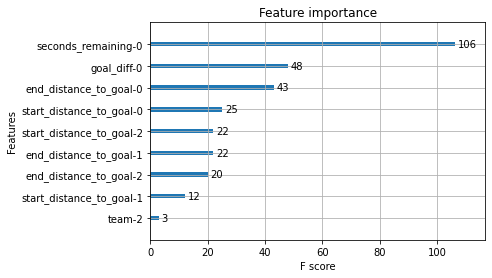

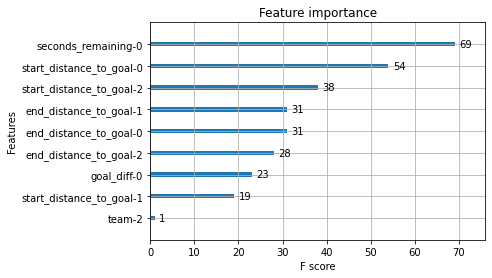

In [29]:
for label in labels:
    plot_importance(models[label])

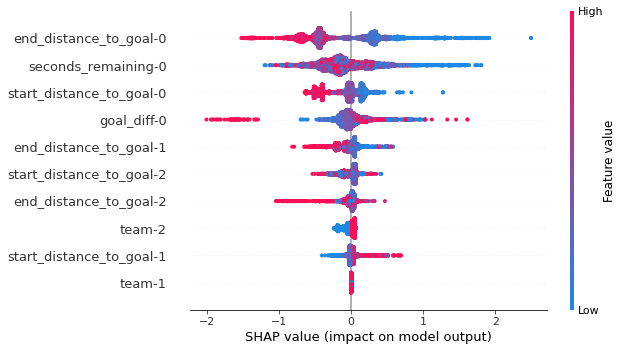

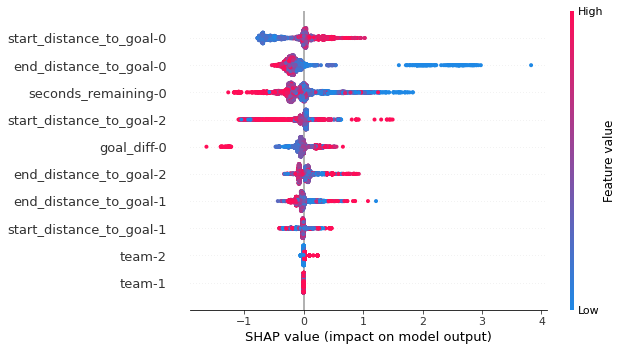

In [30]:
for label in labels:
    explainer = shap.TreeExplainer(models[label])

    shap_values = explainer.shap_values(df_X_test[feat])
    shap.summary_plot(shap_values, df_X_test[feat])

In [31]:
dfs_actions = []
dfs_actions.append(womens)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

In [32]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)
df_actions_predictions = df_actions_predictions.dropna(subset=['start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'scores', 'concedes'])

In [33]:
df_actions_predictions

,game_date,home_team,away_team,period,clock,home_team_skaters,away_team_skaters,home_team_goals,away_team_goals,team,...,detail_4_code,goal_diff,seconds_remaining,start_distance_to_goal,end_distance_to_goal,diff_x,diff_y,distance_covered,scores,concedes
9,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,1900-01-01 00:19:40,5,5,0,0,Olympic (Women) - Olympic Athletes from Russia,...,-1,0,1180,137.783344,92.662020,46.0,-74.0,87.132084,0.004287,0.004803
55,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,1900-01-01 00:18:15,5,4,0,0,Olympic (Women) - Canada,...,-1,0,1095,30.054118,30.054118,0.0,0.0,0.000000,0.028491,0.003540
60,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,1900-01-01 00:18:10,5,4,0,0,Olympic (Women) - Canada,...,-1,0,1090,53.584046,53.584046,0.0,0.0,0.000000,0.030041,0.002498
77,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,1900-01-01 00:17:36,5,4,0,0,Olympic (Women) - Olympic Athletes from Russia,...,-1,0,1056,138.000906,138.000906,0.0,0.0,0.000000,0.008776,0.003978
82,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,1900-01-01 00:17:26,5,4,0,0,Olympic (Women) - Olympic Athletes from Russia,...,-1,0,1046,177.017654,175.086407,2.0,-3.0,3.605551,0.002404,0.002519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50836,2021-02-01,Buffalo Beauts,Boston Pride,3,1900-01-01 00:01:50,5,5,1,7,Boston Pride,...,-1,-6,110,163.108093,63.460618,97.0,23.0,99.689518,0.006318,0.009590
50858,2021-02-01,Buffalo Beauts,Boston Pride,3,1900-01-01 00:01:11,4,5,1,7,Boston Pride,...,-1,-6,71,58.053854,67.684932,1.0,-39.0,39.012818,0.011171,0.004722
50864,2021-02-01,Buffalo Beauts,Boston Pride,3,1900-01-01 00:00:57,4,5,1,7,Buffalo Beauts,...,-1,-6,57,143.000874,108.116835,36.0,-16.0,39.395431,0.003202,0.005172
50865,2021-02-01,Buffalo Beauts,Boston Pride,3,1900-01-01 00:00:54,4,5,1,7,Boston Pride,...,-1,-6,54,108.116835,108.116835,0.0,0.0,0.000000,0.003543,0.012590


In [34]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})
df_base_rates.head(10)

,scores,concedes
0,0.019937,0.008473
1,0.019937,0.008473
2,0.019937,0.008473
3,0.019937,0.008473
4,0.019937,0.008473
5,0.019937,0.008473
6,0.019937,0.008473
7,0.019937,0.008473
8,0.019937,0.008473
9,0.019937,0.008473


In [35]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.019452843705942396

In [36]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions['scores']
)

0.018342736631788998

In [37]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.008378202004430168

In [38]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.007955594570856664

## calculate the VAEP value


In [39]:
dfs_values = []
df_values = pd.DataFrame()

In [40]:
def prev(x: pd.Series) -> pd.Series:
    prev_x = x.shift(1)
    prev_x[:1] = x.values[0]
    return prev_x

In [41]:
sameteam = prev(df_actions_predictions.team_id) == df_actions_predictions.team_id
prev_scores = prev(df_actions_predictions.scores) * sameteam + prev(df_actions_predictions.concedes) * (~sameteam)
prev_concedes = prev(df_actions_predictions.concedes) * sameteam + prev(df_actions_predictions.scores) * (~sameteam)

toolong_idx = abs(prev(df_actions_predictions.seconds_remaining) - df_actions_predictions.seconds_remaining) > 10
prev_scores[toolong_idx] = 0 
prev_concedes[toolong_idx] = 0

prevgoal_idx = prev(df_actions_predictions.event) == 'Goal'
prev_scores[prevgoal_idx] = 0
prev_concedes[prevgoal_idx] = 0

df_values['offensive_value'] = df_actions_predictions.scores - prev_scores
df_values['defensive_value'] = df_actions_predictions.concedes - prev_concedes
df_values['vaep'] = df_values['offensive_value'] + df_values['defensive_value']

In [42]:
df_values['vaep'].count()

5089

In [43]:
df_values['offensive_value'].count()

5089

In [44]:
df_values['vaep'].value_counts(dropna=False)

 0.000000    15
 0.049618     6
 0.013896     5
 0.042518     4
 0.017915     4
             ..
 0.079740     1
-0.015785     1
-0.001560     1
 0.031221     1
 0.031489     1
Name: vaep, Length: 5001, dtype: int64

In [45]:
df_actions_predictions.columns

Index(['game_date', 'home_team', 'away_team', 'period', 'clock',
       'home_team_skaters', 'away_team_skaters', 'home_team_goals',
       'away_team_goals', 'team', 'player', 'event', 'x_coord', 'y_coord',
       'detail_1', 'detail_2', 'detail_3', 'detail_4', 'player_2', 'x_coord_2',
       'y_coord_2', 'game_id', 'is_home', 'is_shot', 'is_goal', 'event_id',
       'team_id', 'player_id', 'detail_1_code', 'detail_2_code',
       'detail_3_code', 'detail_4_code', 'goal_diff', 'seconds_remaining',
       'start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'scores', 'concedes'],
      dtype='object')

In [46]:
df_actions_predictions[['start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'scores', 'concedes']].dropna()

,start_distance_to_goal,end_distance_to_goal,diff_x,diff_y,distance_covered,scores,concedes
9,137.783344,92.662020,46.0,-74.0,87.132084,0.004287,0.004803
55,30.054118,30.054118,0.0,0.0,0.000000,0.028491,0.003540
60,53.584046,53.584046,0.0,0.0,0.000000,0.030041,0.002498
77,138.000906,138.000906,0.0,0.0,0.000000,0.008776,0.003978
82,177.017654,175.086407,2.0,-3.0,3.605551,0.002404,0.002519
...,...,...,...,...,...,...,...
50836,163.108093,63.460618,97.0,23.0,99.689518,0.006318,0.009590
50858,58.053854,67.684932,1.0,-39.0,39.012818,0.011171,0.004722
50864,143.000874,108.116835,36.0,-16.0,39.395431,0.003202,0.005172
50865,108.116835,108.116835,0.0,0.0,0.000000,0.003543,0.012590


In [47]:
df_actions_predictions['scores'].count()

5089

In [48]:
df_actions_predictions['concedes'].count()

5089

## Analysis

In [49]:
df_final = pd.concat([df_actions_predictions,df_values],axis=1).dropna(subset=['vaep'])

In [50]:
df_final['event'].value_counts()

Puck Recovery      1463
Play               1456
Incomplete Play     583
Zone Entry          387
Dump In/Out         373
Shot                357
Takeaway            257
Faceoff Win         172
Penalty Taken        28
Goal                 13
Name: event, dtype: int64

In [51]:
df_ranking = (df_final[['player','team','vaep']]
.groupby(['player','team'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

In [52]:
df_ranking.head(10)

,player,team,vaep_count,vaep_mean,vaep_sum
0,Melodie Daoust,Olympic (Women) - Canada,42,0.073251,3.076559
1,Rebecca Johnston,Olympic (Women) - Canada,68,0.029899,2.033108
2,Taytum Clairmont,Toronto Six,31,0.056307,1.745532
3,Mikyla Grant-Mentis,Toronto Six,51,0.032498,1.657410
4,Marie-Philip Poulin,Olympic (Women) - Canada,68,0.023349,1.587730
5,Sarah Nurse,Olympic (Women) - Canada,50,0.028192,1.409598
6,Kendall Coyne Schofield,Olympic (Women) - United States,58,0.023579,1.367593
7,Tereza Vanisova,Boston Pride,45,0.025437,1.144645
8,Meghan Agosta,Olympic (Women) - Canada,34,0.032841,1.116583
9,Brianne Jenner,Olympic (Women) - Canada,77,0.013996,1.077727


In [53]:
df_rank_events = (df_final[['event','vaep']]
.groupby(['event'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_mean',ascending=False)
.reset_index()
)

In [54]:
df_rank_events

,event,vaep_count,vaep_mean,vaep_sum
0,Goal,13,0.313800,4.079402
1,Shot,357,0.069224,24.713114
2,Zone Entry,387,0.014515,5.617357
3,Incomplete Play,583,0.014287,8.329248
4,Play,1456,0.013564,19.748531
5,Puck Recovery,1463,0.011979,17.525448
6,Takeaway,257,0.011253,2.891896
7,Penalty Taken,28,0.010739,0.300705
8,Dump In/Out,373,0.009956,3.713647
9,Faceoff Win,172,0.008385,1.442181


In [55]:
df_zone_entries = (df_final.loc[womens['event']=='Zone Entry',['detail_1','defensive_value','offensive_value','vaep']]
.groupby(['detail_1'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

In [56]:
df_zone_entries

,detail_1,vaep_count,vaep_mean,vaep_sum
0,Carried,225,0.017700,3.982525
1,Dumped,130,0.008153,1.059954
2,Played,32,0.017965,0.574878


In [57]:
df_final.columns

Index(['game_date', 'home_team', 'away_team', 'period', 'clock',
       'home_team_skaters', 'away_team_skaters', 'home_team_goals',
       'away_team_goals', 'team', 'player', 'event', 'x_coord', 'y_coord',
       'detail_1', 'detail_2', 'detail_3', 'detail_4', 'player_2', 'x_coord_2',
       'y_coord_2', 'game_id', 'is_home', 'is_shot', 'is_goal', 'event_id',
       'team_id', 'player_id', 'detail_1_code', 'detail_2_code',
       'detail_3_code', 'detail_4_code', 'goal_diff', 'seconds_remaining',
       'start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep'],
      dtype='object')